In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset, random_split
import torchvision.datasets as datasets
import os
%matplotlib inline

/home/ddsukhoverkhova/.conda/envs/mc_lib_env/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_data(Jd, l, num_conf, T, num_temps, batch_size, shuffle_opt, opt='train'):
    gen = torch.Generator()
    gen.manual_seed(1234)
    datasets = []
    temps = []
    for j in range(num_temps):
        path = f'data_spins/{Jd}_{opt}/spins_{l}_{T[j]}.npy'
        with open(path, 'rb') as f:
            x = np.load(f)   
        tensor_x = torch.Tensor(x).unsqueeze(1)
        path = f'data_spins/{Jd}_{opt}/answ_{l}_{T[j]}.npy'
        with open(path, 'rb') as f:
            y = np.load(f)
        tensor_y = torch.from_numpy(y).type(torch.float32)

        datasets.append(TensorDataset(tensor_x, tensor_y))
        
        temps.append(T[j])
        
    temps = torch.FloatTensor(temps)
    
    if shuffle_opt == True:
        idx = torch.randperm(temps.shape[0], generator=gen)
        temps = temps[idx].view(temps.size())
        dataset = torch.utils.data.ConcatDataset(datasets)
        return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle_opt, generator=gen), temps
    
    else:
        dataset = torch.utils.data.ConcatDataset(datasets)
        return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle_opt)

In [3]:
class Net(nn.Module):
    def __init__(self, l):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 64, 2)
        self.pool = nn.MaxPool2d(2, 2)
        self.act_hid = nn.ReLU()
        self.fc1 = nn.Linear(64*int(l/2-1)*int(l/2-1), 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = self.act_hid(x)
        x = x.view(-1, 64*int(l/2-1)*int(l/2-1))
        x = self.fc1(x)
        x = self.act_hid(x)
        x = self.fc2(x)
        return x

In [44]:
def train(l, train_dataloader, num_epoch, criterion, batch_size):
    model = Net(l)
    optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-4)
    act = nn.Sigmoid()
    
    errs = []
    outs = []

    for epoch in range(num_epoch):  
        running_loss = 0.0
        accuracy = 0.0
        pbar = tqdm(enumerate(train_dataloader), total=len(train_dataloader))
        for i, data in pbar:
            inputs, labels = data
            #inputs = inputs.to(device)
            #labels = labels.to(device)  
            
            #model.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            #outputs = act(outputs)

            outputs = outputs.squeeze(1) # к одной размерности с labels

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            accuracy += (batch_size - sum(abs(labels - act(outputs)))).float().mean()

            pbar.set_description(
                    f"Loss: {running_loss/((i+1)*batch_size)} "
                    f"Accuracy: {accuracy * 100  / ((i+1)*batch_size)}"
            )
            errs.append(loss.item())
            #outs.append(act(outputs).item())
            
    print('Training completed')
    return model, errs

In [16]:
def testing(model, test_dataloader, criterion, batch_size):
    outp = []
    errors = []
    accuracy = 0.0
    act = nn.Sigmoid()
    with torch.no_grad():
        for i, data in enumerate(test_dataloader):
            inputs, labels = data
            #inputs = inputs.to(device)
            #labels = labels.to(device)  
            model.to(device)
            outputs = model(inputs)
            #outputs = act(outputs)
            outputs = outputs.squeeze(1)
            outp.append(act(outputs).item())
            loss = criterion(outputs, labels)
            errors.append(loss.item())

            accuracy += (1 - sum(abs(labels - act(outputs)))).float().mean()

    print("Accuracy = {}".format(accuracy / len(test_dataloader)))
    return outp, errors

In [17]:
roots = [2.2691853142129728, 2.104982167992544, 1.932307699120554, 1.749339162933206, 1.5536238493280832, 1.34187327905057, 1.109960313758399, 0.8541630993606272, 0.5762735442012712, 0.2885386111960936, 0.03198372863548067]
jds = [0.0, -0.1, -0.2, -0.3, -0.4, -0.5, -0.6, -0.7, -0.8, -0.9, -1.0]
get_crit_T = dict(zip(jds, roots))

In [32]:
### training ###

def train_and_save(Jd, l, num_temps):
    num_conf_tr = 2048
    num_conf_ts = 512
    num_epoch = 1

    T_c = get_crit_T[Jd]
    T = np.round(np.linspace(T_c - 0.3, T_c + 0.3, num_temps), 4)

    criterion = nn.BCEWithLogitsLoss()     

    train_dataloader, temps = load_data(Jd, l, num_conf_tr, T, num_temps, batch_size=4, shuffle_opt=True, opt='train')
    print(f'Start training for L = {l}')
    model, errs = train(l, train_dataloader, num_epoch, criterion, batch_size=4)

    #PATH = f'models/{l}_{Jd}_{T[0]}_{T[-1]}_{num_temps}.pt'
    #torch.save(model.state_dict(), PATH)
    return temps, errs

In [45]:
L = [10, 20, 30, 60]
Jd = 0.0
num_temps = 100
for l in L:
    temps, errors = train_and_save(Jd, l, num_temps)
    np.save(f'data_errors_train/{Jd}_{l}_{num_temps}.npy', errors)
    np.save(f'data_errors_train/{Jd}_{l}_{num_temps}_temps.npy', temps)

Start training for L = 10


Loss: 0.13235502219387854 Accuracy: 64.85651397705078: 100%|██████████| 51200/51200 [02:35<00:00, 328.79it/s] 


Training completed
Start training for L = 20


Loss: 0.0744204319188441 Accuracy: 81.90164184570312: 100%|██████████| 51200/51200 [05:46<00:00, 147.67it/s] 


Training completed
Start training for L = 30


Loss: 0.04855490498159042 Accuracy: 88.55278015136719: 100%|██████████| 51200/51200 [12:53<00:00, 66.22it/s] 


Training completed
Start training for L = 60


Loss: 0.025648216043166885 Accuracy: 94.24524688720703: 100%|██████████| 51200/51200 [52:06<00:00, 16.38it/s]  


Training completed


In [49]:
def errs(errs):
    return np.array([sum(errs[i*2048:(i+1)*2048])/2048 for i in range(num_temps)])

def stds_err(errs):
    return np.array([np.std(errs[i*2048:(i+1)*2048]) for i in range(num_temps)])

In [50]:
Jd = 0.0

num_temps = 100
T_c = get_crit_T[Jd]
T = np.linspace(0.03, 3.5, num_temps)

L = 10
with open(f'data_errors_train/{Jd}_{L}_{num_temps}.npy', 'rb') as f:
    errs_10 = np.load(f) 
with open(f'data_errors_train/{Jd}_{L}_{num_temps}_temps.npy', 'rb') as f:
    temps_10 = np.load(f)

L = 20
with open(f'data_errors_train/{Jd}_{L}_{num_temps}.npy', 'rb') as f:
    errs_20 = np.load(f) 
with open(f'data_errors_train/{Jd}_{L}_{num_temps}_temps.npy', 'rb') as f:
    temps_20 = np.load(f)
    
L = 30
with open(f'data_errors_train/{Jd}_{L}_{num_temps}.npy', 'rb') as f:
    errs_30 = np.load(f) 
with open(f'data_errors_train/{Jd}_{L}_{num_temps}_temps.npy', 'rb') as f:
    temps_30 = np.load(f)
    
L = 60
with open(f'data_errors_train/{Jd}_{L}_{num_temps}.npy', 'rb') as f:
    errs_60 = np.load(f) 
with open(f'data_errors_train/{Jd}_{L}_{num_temps}_temps.npy', 'rb') as f:
    temps_60 = np.load(f)

In [51]:
T_10, errs_10 = zip(*sorted(zip(temps_10, errs(errs_10))))
T_20, errs_20 = zip(*sorted(zip(temps_20, errs(errs_20))))
T_30, errs_30 = zip(*sorted(zip(temps_30, errs(errs_30))))
T_60, errs_60 = zip(*sorted(zip(temps_60, errs(errs_60))))

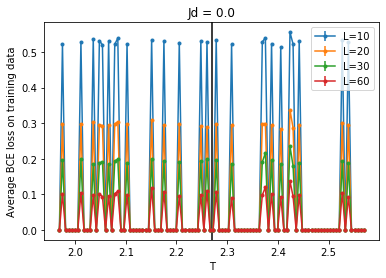

In [52]:
plt.errorbar(T_10, errs_10, yerr=stds_err(errs_10)/1000, marker='.', label='L=10')
plt.errorbar(T_20, errs_20, yerr=stds_err(errs_20)/1000, marker='.', label='L=20')
plt.errorbar(T_30, errs_30, yerr=stds_err(errs_30)/1000, marker='.', label='L=30')
plt.errorbar(T_60, errs_60, yerr=stds_err(errs_60)/1000, marker='.', label='L=60')

plt.title('Jd = 0.0')
plt.xlabel('T')
plt.ylabel('Average BCE loss on training data')

plt.axvline(x=T_c, color='black')
plt.legend()
#plt.xlim(T_c-0.1, T_c+0.1)
plt.show()